In [1]:
%%capture state
from __future__ import division
from __future__ import print_function

import sys, os
sys.path.append('../')

import tensorflow as tf
import numpy as np

from models.neural_network import NeuralNetwork
from models.cnn import CNN

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

#Seed used for all calculations of training and test point indices 
SEED = 14

In [2]:
## Visualization of samples
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

def visualize(image):
    plt.figure(figsize=(1, 1))
    if image.shape[-1] == 1:
        # image is in black and white
        image = image[:, :, 0]
        plt.imshow(image, cmap='Greys')
    else:
        # image is in color
        plt.imshow(image)
    plt.axis('off')
    plt.show()

#Normalize rows of a given matrix
def normalize(matrix):
    matrix_nm = np.zeros_like(matrix)
    for i in range(matrix.shape[0]):
        matrix_nm[i] = matrix[i]/np.linalg.norm(matrix[i]) 
    return matrix_nm

In [6]:
input_shape = (28,28,1)

In [3]:
#Load model from disk
model_name = 'MNIST'
model_save_path = '../trained_models/' + model_name + '-model.json'
weights_save_path = '../trained_models/' + model_name + 'weights'
model = CNN(model_name=model_name, dataset='mnist')
print (model.num_params)
model.load_model(model_save_path, weights_save_path) 
#epochs = 100
#model.train(epochs=epochs)
#model.save_model(model_save_path, weights_save_path)   

3330314
Loaded model from disk


In [4]:
#Get training samples
num_train_samples = 1000
data_indices = model.gen_rand_indices(low=0, high=model.train_data.shape[0], seed=SEED, num_samples=num_train_samples)
train_data = model.train_data[data_indices]
train_data_labels = model.train_labels[data_indices]
train_data_labels_int = np.argmax(train_data_labels, axis=1)

In [5]:
num_test_samples_per_class = 10
num_test_samples = 10*num_test_samples_per_class

#Generate test points
test_indices = model.gen_rand_indices_all_classes(y=model.test_labels, seed=SEED, num_samples=num_test_samples_per_class)

#Get Regular, Noisy, FGSM, BIM, and CW test points
reg_data = model.test_data[test_indices]
noisy_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices],seed=SEED, perturbation='Noisy', eps=0.1)
fgsm_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices],seed=SEED, perturbation='FGSM', eps=0.1)
bim_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices], seed=SEED, perturbation='BIM', iterations=10, eps=0.1)
cw_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices],seed=SEED, perturbation='CW', targeted=False, eps=0.1)
df_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices],seed=SEED, perturbation='DF')
jsma_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices],seed=SEED, perturbation='JSMA')

/root/notebook/cleverhans/cleverhans/src/cleverhans/cleverhans/utils_keras.py:144: UserWarning: Please update your version to keras >= 2.1.3; support for earlier keras versions will be dropped on 2018-07-22
  "Please update your version to keras >= 2.1.3; "


In [6]:
#Whitebox CW Attack
#First get guide images
guide_indices = list()
np.random.seed(SEED)
#Generate guide images for modified CW attacks
for idx in test_indices:
    label = np.argmax(model.test_labels[idx])
    #Add 1 to the label mod 10 to get a target label
    mod_label = (label + 1) % 2
    #Get a test point with the target label
    guide_imgs_indices = np.where(model.train_labels[:,mod_label] == 1)[0]
    #Choose a guide image
    guide_img_idx = np.random.choice(guide_imgs_indices, 1)[0]
    guide_indices.append(guide_img_idx)


#1 Phase Attack
p1_cw_data = model.generate_perturbed_data(model.test_data[test_indices], model.train_labels[guide_indices],seed=SEED, perturbation='CW', targeted=True, x_tar = model.train_data[guide_indices], use_cos_norm_reg=True, eps=0.1)

#2 Phase Attack
#Phase 1: Generate targeted adversarial images
tar_cw_data = model.generate_perturbed_data(model.test_data[test_indices], model.train_labels[guide_indices],seed=SEED, perturbation='CW', targeted=True, use_cos_norm_reg=False, eps=0.1)
#Phase 2: Optimize for higher cosine sim and smaller norm of gradient vector
p2_cw_data = model.generate_perturbed_data(tar_cw_data, model.train_labels[guide_indices],seed=SEED, perturbation='CW', targeted=True, x_tar = model.train_data[guide_indices], use_cos_norm_reg=True, eps=0.1)

Loss: 1458.72095, Cos: -1.00000, Norm: 131.72092
Loss: 1188.99084, Cos: -1.00000, Norm: 109.80309
Loss: 885.07648, Cos: -1.00000, Norm: 83.25176
Loss: 53.78639, Cos: -1.00000, Norm: 1.11991
Loss: 58.32988, Cos: -1.00000, Norm: 0.10698
Loss: 71.98215, Cos: -1.00000, Norm: 0.01976
Loss: 85.26105, Cos: -1.00000, Norm: 0.00550
Loss: 97.07374, Cos: -1.00000, Norm: 0.00188
Loss: 107.14810, Cos: -1.00000, Norm: 0.00077
Loss: 115.43658, Cos: -1.00000, Norm: 0.00036
Loss: 121.99779, Cos: -1.00000, Norm: 0.00020
Loss: 126.94438, Cos: -1.00000, Norm: 0.00011
Loss: 130.41595, Cos: -1.00000, Norm: 0.00008
Loss: 132.56268, Cos: -1.00000, Norm: 0.00006
Loss: 133.53621, Cos: -1.00000, Norm: 0.00004
Loss: 133.48413, Cos: -1.00000, Norm: 0.00003
Loss: 132.54634, Cos: -1.00000, Norm: 0.00003
Loss: 130.85399, Cos: -1.00000, Norm: 0.00002
Loss: 128.52795, Cos: -1.00000, Norm: 0.00002
Loss: 125.67899, Cos: -1.00000, Norm: 0.00002
Loss: 122.40736, Cos: -1.00000, Norm: 0.00002
Loss: 1531.66431, Cos: -0.93996,

Loss: 63.66782, Cos: -0.78785, Norm: 0.00001
Loss: 60.52286, Cos: -0.78670, Norm: 0.00002
Loss: 57.39937, Cos: -0.78680, Norm: 0.00003
Loss: 54.32937, Cos: -0.78737, Norm: 0.00003
Loss: 51.33207, Cos: -0.78725, Norm: 0.00004
Loss: 48.45358, Cos: -0.78874, Norm: 0.00007
Loss: 45.70632, Cos: -0.79141, Norm: 0.00009
Loss: 43.07973, Cos: -0.79303, Norm: 0.00014
Loss: 40.59567, Cos: -0.79504, Norm: 0.00021
Loss: 38.26733, Cos: -0.79835, Norm: 0.00032
Loss: 36.07143, Cos: -0.80053, Norm: 0.00051
Loss: 34.02982, Cos: -0.80386, Norm: 0.00080
Loss: 32.12006, Cos: -0.80633, Norm: 0.00128
Loss: 30.33053, Cos: -0.80712, Norm: 0.00205
Loss: 28.66307, Cos: -0.80683, Norm: 0.00328
Loss: 27.15809, Cos: -0.80984, Norm: 0.00520
Loss: 25.75752, Cos: -0.81066, Norm: 0.00814
Loss: 24.48761, Cos: -0.81164, Norm: 0.01302
Loss: 23.36156, Cos: -0.81422, Norm: 0.02033
Loss: 22.38403, Cos: -0.81865, Norm: 0.03082
Loss: 21.50856, Cos: -0.82004, Norm: 0.04519
Loss: 20.76455, Cos: -0.81927, Norm: 0.06575
Loss: 20.1

Loss: 98.09270, Cos: -1.00000, Norm: 0.00000
Loss: 98.03397, Cos: -1.00000, Norm: 0.00000
Loss: 97.27020, Cos: -1.00000, Norm: 0.00000
Loss: 95.91503, Cos: -1.00000, Norm: 0.00000
Loss: 94.07581, Cos: -1.00000, Norm: 0.00000
Loss: 91.85171, Cos: -1.00000, Norm: 0.00000
Loss: 89.33236, Cos: -1.00000, Norm: 0.00000
Loss: 1769.34375, Cos: -1.00000, Norm: 162.80891
Loss: 1552.24146, Cos: -1.00000, Norm: 147.29170
Loss: 949.21387, Cos: -1.00000, Norm: 91.86742
Loss: 38.56628, Cos: -1.00000, Norm: 0.44727
Loss: 42.82376, Cos: -1.00000, Norm: 0.03983
Loss: 51.75833, Cos: -1.00000, Norm: 0.00743
Loss: 61.08530, Cos: -1.00000, Norm: 0.00204
Loss: 70.13612, Cos: -1.00000, Norm: 0.00075
Loss: 78.63753, Cos: -1.00000, Norm: 0.00033
Loss: 86.45751, Cos: -1.00000, Norm: 0.00018
Loss: 93.53841, Cos: -1.00000, Norm: 0.00011
Loss: 99.86670, Cos: -1.00000, Norm: 0.00007
Loss: 105.45596, Cos: -1.00000, Norm: 0.00005
Loss: 110.33582, Cos: -1.00000, Norm: 0.00003
Loss: 114.54536, Cos: -1.00000, Norm: 0.000

Loss: 23.84384, Cos: -0.98580, Norm: 0.00002
Loss: 23.18990, Cos: -0.98575, Norm: 0.00003
Loss: 22.57090, Cos: -0.98568, Norm: 0.00004
Loss: 21.98710, Cos: -0.98581, Norm: 0.00006
Loss: 21.43355, Cos: -0.98584, Norm: 0.00008
Loss: 20.90891, Cos: -0.98582, Norm: 0.00012
Loss: 20.41130, Cos: -0.98573, Norm: 0.00018
Loss: 19.93924, Cos: -0.98558, Norm: 0.00025
Loss: 19.49350, Cos: -0.98557, Norm: 0.00035
Loss: 19.07060, Cos: -0.98550, Norm: 0.00049
Loss: 18.67081, Cos: -0.98551, Norm: 0.00069
Loss: 18.29115, Cos: -0.98540, Norm: 0.00095
Loss: 17.93277, Cos: -0.98540, Norm: 0.00129
Loss: 17.59435, Cos: -0.98543, Norm: 0.00176
Loss: 17.27448, Cos: -0.98543, Norm: 0.00238
Loss: 16.97275, Cos: -0.98543, Norm: 0.00315
Loss: 16.68980, Cos: -0.98556, Norm: 0.00410
Loss: 16.42190, Cos: -0.98521, Norm: 0.00553
Loss: 16.17432, Cos: -0.98502, Norm: 0.00740
Loss: 15.94413, Cos: -0.98493, Norm: 0.00952
Loss: 15.73239, Cos: -0.98500, Norm: 0.01198
Loss: 15.53769, Cos: -0.98509, Norm: 0.01483
Loss: 15.3

Loss: 95.77570, Cos: -1.00000, Norm: 0.00000
Loss: 102.40253, Cos: -1.00000, Norm: 0.00000
Loss: 108.26546, Cos: -1.00000, Norm: 0.00000
Loss: 113.38753, Cos: -1.00000, Norm: 0.00000
Loss: 117.80295, Cos: -1.00000, Norm: 0.00000
Loss: 121.55311, Cos: -1.00000, Norm: 0.00000
Loss: 124.68345, Cos: -1.00000, Norm: 0.00000
Loss: 127.24122, Cos: -1.00000, Norm: 0.00000
Loss: 129.27376, Cos: -1.00000, Norm: 0.00000
Loss: 130.82741, Cos: -1.00000, Norm: 0.00000
Loss: 131.94656, Cos: -1.00000, Norm: 0.00000
Loss: 1299.65027, Cos: -0.99952, Norm: 126.55237
Loss: 16.43482, Cos: -0.99852, Norm: 0.36429
Loss: 17.87617, Cos: -0.99798, Norm: 0.00812
Loss: 23.20337, Cos: -0.99777, Norm: 0.00087
Loss: 28.41350, Cos: -0.99766, Norm: 0.00020
Loss: 33.20664, Cos: -0.99751, Norm: 0.00006
Loss: 37.47747, Cos: -0.99749, Norm: 0.00003
Loss: 41.18831, Cos: -0.99743, Norm: 0.00002
Loss: 44.34238, Cos: -0.99739, Norm: 0.00001
Loss: 46.96374, Cos: -0.99738, Norm: 0.00000
Loss: 49.08712, Cos: -0.99737, Norm: 0.00

Loss: 13.23183, Cos: -0.99268, Norm: 0.02425
Loss: 13.11575, Cos: -0.99257, Norm: 0.02604
Loss: 13.01010, Cos: -0.99252, Norm: 0.02851
Loss: 12.91381, Cos: -0.99241, Norm: 0.03130
Loss: 12.82368, Cos: -0.99233, Norm: 0.03357
Loss: 12.74141, Cos: -0.99231, Norm: 0.03503
Loss: 12.66765, Cos: -0.99236, Norm: 0.03558
Loss: 12.60088, Cos: -0.99228, Norm: 0.03539
Loss: 12.54200, Cos: -0.99230, Norm: 0.03475
Loss: 12.48470, Cos: -0.99218, Norm: 0.03368
Loss: 12.43081, Cos: -0.99209, Norm: 0.03254
Loss: 12.38000, Cos: -0.99203, Norm: 0.03139
Loss: 12.33510, Cos: -0.99200, Norm: 0.03055
Loss: 12.29356, Cos: -0.99192, Norm: 0.02984
Loss: 12.25714, Cos: -0.99194, Norm: 0.02937
Loss: 12.22493, Cos: -0.99201, Norm: 0.02921
Loss: 12.19339, Cos: -0.99197, Norm: 0.02920
Loss: 12.16299, Cos: -0.99194, Norm: 0.02926
Loss: 12.13535, Cos: -0.99192, Norm: 0.02948
Loss: 12.11113, Cos: -0.99196, Norm: 0.02982
Loss: 12.08829, Cos: -0.99194, Norm: 0.03013
Loss: 12.06859, Cos: -0.99189, Norm: 0.03062
Loss: 12.0

Loss: 15.09270, Cos: -0.99529, Norm: 0.00218
Loss: 22.04088, Cos: -0.99540, Norm: 0.00016
Loss: 27.64438, Cos: -0.99554, Norm: 0.00005
Loss: 31.43467, Cos: -0.99559, Norm: 0.00002
Loss: 33.55925, Cos: -0.99562, Norm: 0.00001
Loss: 34.35951, Cos: -0.99568, Norm: 0.00001
Loss: 34.19891, Cos: -0.99575, Norm: 0.00001
Loss: 33.38313, Cos: -0.99577, Norm: 0.00001
Loss: 32.14352, Cos: -0.99580, Norm: 0.00001
Loss: 30.64956, Cos: -0.99576, Norm: 0.00001
Loss: 86.27583, Cos: -0.83668, Norm: 7.79090
Loss: 13.57468, Cos: -0.80548, Norm: 0.00212
Loss: 22.48905, Cos: -0.78765, Norm: 0.00007
Loss: 31.68462, Cos: -0.78177, Norm: 0.00001
Loss: 40.07159, Cos: -0.77936, Norm: 0.00000
Loss: 47.27768, Cos: -0.77827, Norm: 0.00000
Loss: 53.21721, Cos: -0.77856, Norm: 0.00000
Loss: 57.92242, Cos: -0.77946, Norm: 0.00000
Loss: 61.48299, Cos: -0.78019, Norm: 0.00000
Loss: 64.01147, Cos: -0.78024, Norm: 0.00000
Loss: 65.63757, Cos: -0.78044, Norm: 0.00000
Loss: 66.46286, Cos: -0.77897, Norm: 0.00000
Loss: 66.6

Loss: 3.53501, Cos: -0.00000, Norm: 0.00157
Loss: 3.41536, Cos: -0.00000, Norm: 0.00182
Loss: 3.30091, Cos: -0.00000, Norm: 0.00206
Loss: 3.19180, Cos: -0.00000, Norm: 0.00234
Loss: 3.08767, Cos: -0.00000, Norm: 0.00263
Loss: 2.98827, Cos: -0.00000, Norm: 0.00295
Loss: 2.89346, Cos: -0.00000, Norm: 0.00329
Loss: 2.80306, Cos: -0.00000, Norm: 0.00366
Loss: 2.71688, Cos: -0.00000, Norm: 0.00407
Loss: 2.63453, Cos: -0.00000, Norm: 0.00449
Loss: 2.55616, Cos: -0.00000, Norm: 0.00495
Loss: 2.48124, Cos: -0.00000, Norm: 0.00541
Loss: 2.41002, Cos: -0.00000, Norm: 0.00592
Loss: 2.34201, Cos: -0.00000, Norm: 0.00644
Loss: 2.27721, Cos: -0.00000, Norm: 0.00698
Loss: 209.49698, Cos: -1.00000, Norm: 19.94970
Loss: 13.24575, Cos: -1.00000, Norm: 0.00269
Loss: 18.83954, Cos: -1.00000, Norm: 0.00004
Loss: 24.89500, Cos: -1.00000, Norm: 0.00000
Loss: 30.78901, Cos: -1.00000, Norm: 0.00000
Loss: 36.27222, Cos: -1.00000, Norm: 0.00000
Loss: 41.23767, Cos: -1.00000, Norm: 0.00000
Loss: 45.64492, Cos: -1

Loss: 113.39861, Cos: -1.00000, Norm: 0.00000
Loss: 116.27731, Cos: -1.00000, Norm: 0.00000
Loss: 118.66241, Cos: -1.00000, Norm: 0.00000
Loss: 120.59592, Cos: -1.00000, Norm: 0.00000
Loss: 122.11729, Cos: -1.00000, Norm: 0.00000
Loss: 123.26400, Cos: -1.00000, Norm: 0.00000
Loss: 124.07176, Cos: -1.00000, Norm: 0.00000
Loss: 273.46912, Cos: -0.96121, Norm: 26.38570
Loss: 13.57826, Cos: -0.95885, Norm: 0.00033
Loss: 20.65197, Cos: -0.96185, Norm: 0.00000
Loss: 28.36889, Cos: -0.96400, Norm: 0.00000
Loss: 36.00758, Cos: -0.96679, Norm: 0.00000
Loss: 43.23920, Cos: -0.96857, Norm: 0.00000
Loss: 49.91809, Cos: -0.96956, Norm: 0.00000
Loss: 55.98499, Cos: -0.97062, Norm: 0.00000
Loss: 61.41741, Cos: -0.97173, Norm: 0.00000
Loss: 66.21333, Cos: -0.97227, Norm: 0.00000
Loss: 70.39812, Cos: -0.97281, Norm: 0.00000
Loss: 74.00175, Cos: -0.97347, Norm: 0.00000
Loss: 77.04852, Cos: -0.97335, Norm: 0.00000
Loss: 79.58746, Cos: -0.97370, Norm: 0.00000
Loss: 81.65172, Cos: -0.97401, Norm: 0.00000
L

Loss: 14.90097, Cos: -1.00000, Norm: 0.00039
Loss: 23.53742, Cos: -1.00000, Norm: 0.00000
Loss: 32.97697, Cos: -1.00000, Norm: 0.00000
Loss: 42.33429, Cos: -1.00000, Norm: 0.00000
Loss: 51.23979, Cos: -1.00000, Norm: 0.00000
Loss: 59.52400, Cos: -1.00000, Norm: 0.00000
Loss: 67.11574, Cos: -1.00000, Norm: 0.00000
Loss: 73.99531, Cos: -1.00000, Norm: 0.00000
Loss: 80.17089, Cos: -1.00000, Norm: 0.00000
Loss: 85.66624, Cos: -1.00000, Norm: 0.00000
Loss: 90.51439, Cos: -1.00000, Norm: 0.00000
Loss: 94.75397, Cos: -1.00000, Norm: 0.00000
Loss: 98.42600, Cos: -1.00000, Norm: 0.00000
Loss: 101.57194, Cos: -1.00000, Norm: 0.00000
Loss: 104.23235, Cos: -1.00000, Norm: 0.00000
Loss: 106.44630, Cos: -1.00000, Norm: 0.00000
Loss: 108.25124, Cos: -1.00000, Norm: 0.00000
Loss: 109.68305, Cos: -1.00000, Norm: 0.00000
Loss: 110.77566, Cos: -1.00000, Norm: 0.00000
Loss: 111.56084, Cos: -1.00000, Norm: 0.00000
Loss: 139.28964, Cos: -0.99884, Norm: 12.93013
Loss: 12.79026, Cos: -0.99824, Norm: 0.00912
L

In [7]:
#Reset tf.graph() as Cleverhans modifies the graph
tf.reset_default_graph()

#Reload the model and weights
model = CNN(model_name=model_name, dataset='mnist')
model.load_model(model_save_path, weights_save_path)    

Loaded model from disk


In [8]:
model.model.evaluate(model.test_data, model.test_labels)

6042/6042 [==============================] - 1s 140us/step


[0.016930079731469826, 0.99453823237338634]

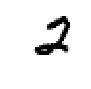

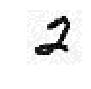

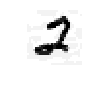

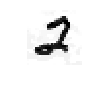

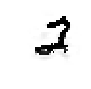

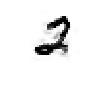

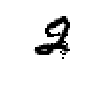

In [9]:
#Lets visualize one sample from each dataset
x_vis = np.random.choice(range(0,num_test_samples), 1)
visualize(reg_data[x_vis].reshape(input_shape))
visualize(noisy_data[x_vis].reshape(input_shape))
visualize(fgsm_data[x_vis].reshape(input_shape))
visualize(bim_data[x_vis].reshape(input_shape))
visualize(cw_data[x_vis].reshape(input_shape))
visualize(df_data[x_vis].reshape(input_shape))
visualize(jsma_data[x_vis].reshape(input_shape))


#visualize(p1_cw_data[x_vis].reshape(32,32,3))
#visualize(p2_cw_data[x_vis].reshape(32,32,3))


In [10]:
#Get predictions
reg_preds = model.model.predict(reg_data.reshape(-1,*input_shape))
noisy_preds = model.model.predict(noisy_data.reshape(-1,*input_shape))
fgsm_preds = model.model.predict(fgsm_data.reshape(-1,*input_shape))
bim_preds = model.model.predict(bim_data.reshape(-1,*input_shape))
cw_preds = model.model.predict(cw_data.reshape(-1,*input_shape))
df_preds = model.model.predict(df_data.reshape(-1,*input_shape))
jsma_preds = model.model.predict(jsma_data.reshape(-1,*input_shape))
#p1_cw_preds = model.model.predict(p1_cw_data.reshape(-1,32,32,3))
#p2_cw_preds = model.model.predict(p2_cw_data.reshape(-1,32,32,3))

In [11]:
#Convert preds to labels
reg_labels = np.zeros(reg_preds.shape)
reg_labels[np.arange(num_test_samples),np.argmax(reg_preds, axis=1)] = 1

noisy_labels = np.zeros(noisy_preds.shape)
noisy_labels[np.arange(num_test_samples),np.argmax(noisy_preds, axis=1)] = 1

fgsm_labels = np.zeros(fgsm_preds.shape)
fgsm_labels[np.arange(num_test_samples),np.argmax(fgsm_preds, axis=1)] = 1

bim_labels = np.zeros(bim_preds.shape)
bim_labels[np.arange(num_test_samples),np.argmax(bim_preds, axis=1)] = 1

cw_labels = np.zeros(cw_preds.shape)
cw_labels[np.arange(num_test_samples),np.argmax(cw_preds, axis=1)] = 1

df_labels = np.zeros(df_preds.shape)
df_labels[np.arange(num_test_samples),np.argmax(df_preds, axis=1)] = 1

jsma_labels = np.zeros(jsma_preds.shape)
jsma_labels[np.arange(num_test_samples),np.argmax(jsma_preds, axis=1)] = 1


"""
p1_cw_labels = np.zeros(p1_cw_preds.shape)
p1_cw_labels[np.arange(num_test_samples),np.argmax(p1_cw_preds, axis=1)] = 1

p2_cw_labels = np.zeros(p2_cw_preds.shape)
p2_cw_labels[np.arange(num_test_samples),np.argmax(p2_cw_preds, axis=1)] = 1"""

'\np1_cw_labels = np.zeros(p1_cw_preds.shape)\np1_cw_labels[np.arange(num_test_samples),np.argmax(p1_cw_preds, axis=1)] = 1\n\np2_cw_labels = np.zeros(p2_cw_preds.shape)\np2_cw_labels[np.arange(num_test_samples),np.argmax(p2_cw_preds, axis=1)] = 1'

In [12]:
#Check preds to ensure adversarial samples were generated correctly
print (np.argmax(reg_preds, axis=1))
print (np.argmax(noisy_preds, axis=1))
print (np.argmax(fgsm_preds, axis=1))
print (np.argmax(bim_preds, axis=1))
print (np.argmax(cw_preds, axis=1))
print (np.argmax(df_preds, axis=1))
print (np.argmax(jsma_preds, axis=1))
#print (np.argmax(p1_cw_preds, axis=1))
#print (np.argmax(p2_cw_preds, axis=1))

[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 7 7 7 7
 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 3]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 7 7 7 7
 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 7]
[0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 1 1 2 2 2 7 2 2 3 7 2 2 2 3 3 2 3 3 3 3
 3 9 3 4 9 4 4 4 4 4 8 4 4 3 5 5 5 5 3 5 5 3 5 6 6 6 6 6 6 6 6 6 6 7 7 7 3
 7 7 2 7 7 7 0 8 8 8 8 8 8 8 8 8 9 9 5 9 9 8 4 4 9 7]
[0 0 0 0 0 0 0 0 5 0 1 0 7 1 1 1 8 8 1 2 2 2 7 2 2 3 7 2 2 2 3 3 2 3 3 3 3
 3 9 3 9 9 4 4 4 4 4 8 4 4 3 5 5 5 5 3 5 5 3 5 6 6 6 6 6 6 6 6 6 6 7 7 7 3
 7 7 2 7 7 2 0 8 8 8 8 8 8 8 8 8 4 4 5 9 9 8 4 4 9 7]
[2 9 6 5 5 9 2 2 5 2 8 0 3 9 8 2 8 8 3 2 3 3 7 3 7 3 7 1 1 1 9 5 2 5 5 5 5
 9 9 9 9 9 8 2 9 9 9 8 7 7 3 3 3 3 3 3 3 9 3 9 5 0 4 5 4 5 3 5 5 8 9 9 9 3
 2 8 2 5 3 2 0 9 9 9 3 3 9 5 9 6 4

In [13]:
#Get gradients for all test points
grads_reg = model.get_gradients_wrt_params(reg_data, reg_labels)
grads_noisy = model.get_gradients_wrt_params(noisy_data, noisy_labels)
grads_fgsm = model.get_gradients_wrt_params(fgsm_data, fgsm_labels)
grads_bim = model.get_gradients_wrt_params(bim_data, bim_labels)
grads_cw = model.get_gradients_wrt_params(cw_data, cw_labels)
grads_df = model.get_gradients_wrt_params(df_data, df_labels)
grads_jsma = model.get_gradients_wrt_params(jsma_data, jsma_labels)
#grads_p1_cw = model.get_gradients_wrt_params(p1_cw_data, p1_cw_labels)
#grads_p2_cw = model.get_gradients_wrt_params(p2_cw_data, p2_cw_labels)

#Get gradients for training points 
grads_train = model.get_gradients_wrt_params(train_data, train_data_labels)

In [14]:
grads_reg_nm = normalize(grads_reg)
grads_noisy_nm = normalize(grads_noisy)
grads_fgsm_nm = normalize(grads_fgsm)
grads_bim_nm = normalize(grads_bim)
grads_cw_nm = normalize(grads_cw)
grads_df_nm = normalize(grads_df)
grads_jsma_nm = normalize(grads_jsma)
#grads_p1_cw_nm = normalize(grads_p1_cw)
#grads_p2_cw_nm = normalize(grads_p2_cw)
grads_train_nm = normalize(grads_train)

In [15]:
#Get norms 
grads_reg_norms = np.sqrt(np.dot(grads_reg, grads_reg.T)).diagonal()
grads_noisy_norms = np.sqrt(np.dot(grads_noisy, grads_noisy.T)).diagonal()
grads_bim_norms = np.sqrt(np.dot(grads_bim, grads_bim.T)).diagonal()
grads_fgsm_norms = np.sqrt(np.dot(grads_fgsm, grads_fgsm.T)).diagonal()
grads_cw_norms = np.sqrt(np.dot(grads_cw, grads_cw.T)).diagonal()
grads_df_norms = np.sqrt(np.dot(grads_df, grads_df.T)).diagonal()
grads_jsma_norms = np.sqrt(np.dot(grads_jsma, grads_jsma.T)).diagonal()
#grads_p1_cw_norms = np.sqrt(np.dot(grads_p1_cw, grads_p1_cw.T)).diagonal()
#grads_p2_cw_norms = np.sqrt(np.dot(grads_p2_cw, grads_p2_cw.T)).diagonal()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in sqrt
  


In [16]:
#Get cosine similarity matrix
cos_sim_reg = np.dot(grads_reg_nm, grads_train_nm.T)
cos_sim_noisy = np.dot(grads_noisy_nm, grads_train_nm.T)
cos_sim_fgsm = np.dot(grads_fgsm_nm, grads_train_nm.T)
cos_sim_bim = np.dot(grads_bim_nm, grads_train_nm.T)
cos_sim_cw = np.dot(grads_cw_nm, grads_train_nm.T)
cos_sim_df = np.dot(grads_df_nm, grads_train_nm.T)
cos_sim_jsma = np.dot(grads_jsma_nm, grads_train_nm.T)
#cos_sim_p1_cw = np.dot(grads_p1_cw_nm, grads_train_nm.T)
#cos_sim_p2_cw = np.dot(grads_p2_cw_nm, grads_train_nm.T)

In [20]:
#Separate Using Cos Sim
eta = 0.75

count = 0.0
for i in range(num_test_samples):
    if np.max(cos_sim_reg[i]) > eta:
        count+=1.0
        
print ('Regular: %.4f' % ( count/num_test_samples))

count = 0.0
for i in range(num_test_samples):
    if np.max(cos_sim_noisy[i]) > eta:
        count+=1.0
    
print ('Noisy:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_fgsm[i]) > eta:
        count+=1.0
        
print ('FGSM:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_bim[i]) > eta:
        count+=1.0
        
print ('BIM:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_cw[i]) > eta:
        count+=1.0
    
print ('CW: %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_df[i]) > eta:
        count+=1.0
    
print ('DF: %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_jsma[i]) > eta:
        count+=1.0
    
print ('JSMA: %.4f' % ( count/num_test_samples))
"""
count = 0.0
for i in range(num_test_samples):
    if np.max(cos_sim_p1_cw[i]) > eta:
        count+=1.0
        
print ('1 Phase CW:  %.4f' % ( count/num_test_samples))

count = 0.0
for i in range(num_test_samples):
    if np.max(cos_sim_p2_cw[i]) > eta:
        count+=1.0
        
print ('2 Phase CW:  %.4f' % ( count/num_test_samples))
"""


Regular: 0.8000
Noisy:  0.7800
FGSM:  0.4400
BIM:  0.4100
CW: 0.0100
DF: 0.0200
JSMA: 0.0100


"\ncount = 0.0\nfor i in range(num_test_samples):\n    if np.max(cos_sim_p1_cw[i]) > eta:\n        count+=1.0\n        \nprint ('1 Phase CW:  %.4f' % ( count/num_test_samples))\n\ncount = 0.0\nfor i in range(num_test_samples):\n    if np.max(cos_sim_p2_cw[i]) > eta:\n        count+=1.0\n        \nprint ('2 Phase CW:  %.4f' % ( count/num_test_samples))\n"

In [21]:
#Separate using just norm
gamma = 0.15

count = 0.0
for i in range(num_test_samples):
    if grads_reg_norms[i] < gamma:
        count+=1.0
        
print ('Regular: %.4f' % ( count/num_test_samples))

count = 0.0
for i in range(num_test_samples):
    if grads_noisy_norms[i] < gamma:
        count+=1.0
    
print ('Noisy:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_fgsm_norms[i] < gamma:
        count+=1.0
        
print ('FGSM:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_bim_norms[i] < gamma:
        count+=1.0
        
print ('BIM:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_cw_norms[i] < gamma:
        count+=1.0
    
print ('CW: %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_df_norms[i] < gamma:
        count+=1.0
    
print ('DF: %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_jsma_norms[i] < gamma:
        count+=1.0
    
print ('JSMA: %.4f' % ( count/num_test_samples))
"""
count=0.0
for i in range(num_test_samples):
    if grads_p1_cw_norms[i] < gamma:
        count+=1.0
    
print ('1 Phase CW: %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_p2_cw_norms[i] < gamma:
        count+=1.0
    
print ('2 Phase CW: %.4f' % ( count/num_test_samples))
"""

Regular: 0.9300
Noisy:  0.9200
FGSM:  0.2400
BIM:  0.2100
CW: 0.0000
DF: 0.0000
JSMA: 0.0000


"\ncount=0.0\nfor i in range(num_test_samples):\n    if grads_p1_cw_norms[i] < gamma:\n        count+=1.0\n    \nprint ('1 Phase CW: %.4f' % ( count/num_test_samples))\n\ncount=0.0\nfor i in range(num_test_samples):\n    if grads_p2_cw_norms[i] < gamma:\n        count+=1.0\n    \nprint ('2 Phase CW: %.4f' % ( count/num_test_samples))\n"

In [22]:
#Use both cos and norm

count = 0.0
for i in range(num_test_samples):
    if np.max(cos_sim_reg[i]) > eta and grads_reg_norms[i] < gamma:
        count+=1.0
        
print ('Regular: %.4f' % ( count/num_test_samples))

count = 0.0
for i in range(num_test_samples):
    if np.max(cos_sim_noisy[i]) > eta and grads_noisy_norms[i] < gamma:
        count+=1.0
    
print ('Noisy:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_fgsm[i]) > eta and grads_fgsm_norms[i] < gamma:
        count+=1.0
        
print ('FGSM:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_bim[i]) > eta and grads_bim_norms[i] < gamma:
        count+=1.0
        
print ('BIM:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_cw[i]) > eta and grads_cw_norms[i] < gamma:
        count+=1.0
    
print ('CW: %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_df[i]) > eta and grads_df_norms[i] < gamma:
        count+=1.0
    
print ('DF: %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_jsma[i]) > eta and grads_jsma_norms[i] < gamma:
        count+=1.0
    
print ('JSMA: %.4f' % ( count/num_test_samples))

"""
count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_p1_cw[i]) > eta and grads_p1_cw_norms[i] < gamma:
        count+=1.0
    
print ('1 Phase CW: %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_p2_cw[i]) > eta and grads_p2_cw_norms[i] < gamma:
        count+=1.0
    
print ('2 Phase CW: %.4f' % ( count/num_test_samples))
"""

Regular: 0.7700
Noisy:  0.7600
FGSM:  0.1500
BIM:  0.1300
CW: 0.0000
DF: 0.0000
JSMA: 0.0000


"\ncount=0.0\nfor i in range(num_test_samples):\n    if np.max(cos_sim_p1_cw[i]) > eta and grads_p1_cw_norms[i] < gamma:\n        count+=1.0\n    \nprint ('1 Phase CW: %.4f' % ( count/num_test_samples))\n\ncount=0.0\nfor i in range(num_test_samples):\n    if np.max(cos_sim_p2_cw[i]) > eta and grads_p2_cw_norms[i] < gamma:\n        count+=1.0\n    \nprint ('2 Phase CW: %.4f' % ( count/num_test_samples))\n"

In [23]:
def avg_l2_distortion(orig, adv):
    """Get the mean l2 distortion between two orig and adv images"""
    l2_dist = 0.0
    for i in range(orig.shape[0]):
        l2_dist+= np.linalg.norm(orig[i] - adv[i])
    return l2_dist/orig.shape[0]

In [25]:
print (avg_l2_distortion(reg_data, fgsm_data))
print (avg_l2_distortion(reg_data, bim_data))
print (avg_l2_distortion(reg_data, cw_data))
print (avg_l2_distortion(reg_data, df_data))
print (avg_l2_distortion(reg_data, jsma_data))
#print (avg_l2_distortion(reg_data, p1_cw_data))
#print (avg_l2_distortion(reg_data, p2_cw_data))

1.95302713871
1.70902524352
2.89489769161
1.58925069615
4.78124079108
